# Deepfake Detection Baseline Model

This notebook explains the baseline model for distinguishing between deepfake and real face pictures.


In [16]:
# Importing essential libraries for our project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Exploring and Understanding the Dataset

In this section, we will delve into our dataset, gaining a comprehensive understanding of the data we are working with. This exploration is a crucial step in any data-driven project as it allows us to grasp the characteristics, structure, and potential insights hidden within our data.


In [19]:
image_size = (256, 256)

train_ds, val_ds = image_dataset_from_directory(
    "/kaggle/input/deepfakedetection-lw/Project_Data/real_and_fake_face",
    validation_split=0.2,
    color_mode = 'rgb', #added by MP on 07/09 at 10 am
    subset="both",
    label_mode = "categorical",
    seed=123,
    batch_size = 32,
    image_size=image_size)

Found 2016 files belonging to 2 classes.
Using 1613 files for training.
Using 403 files for validation.


## Dataset Overview :file_folder:

Our dataset comprises a collection of images, and our goal is to distinguish between deepfake and real face pictures. Before we dive into the model building process, let's take a closer look at our data:

- **Number of Samples:** We will first determine the total number of samples in our dataset.
- **Data Distribution:** We will explore the distribution of deepfake and real images to understand the class balance.
- **Sample Inspection:** We'll peek into a few sample images to get an initial sense of the data.

In [20]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [21]:
# Iterate through the dataset

for batch in train_ds:
    # Access the input images and labels in the batch
    images, labels = batch

    # Explore the contents of each batch
    print("Batch of Images Shape:", images.shape)
    print("Batch of Labels Shape:", labels.shape)

    first_image = images[0]
    first_label = labels[0]

    # Print some information about the first image and label
    print("Shape of the First Image:", first_image.shape)
    print("First Label:", first_label)
    
    # Break the loop if you want to explore just the first batch
    break


Batch of Images Shape: (32, 256, 256, 3)
Batch of Labels Shape: (32, 2)
Shape of the First Image: (256, 256, 3)
First Label: tf.Tensor([0. 1.], shape=(2,), dtype=float32)


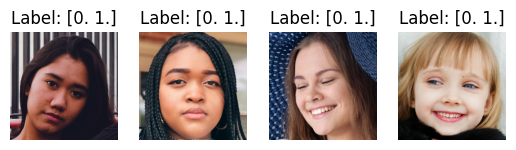

In [22]:
for images, labels in train_ds:
    num_images_to_display = 4
    
    for i in range(num_images_to_display):
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the tensor to a NumPy array
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    
    plt.show()
    break
# label: [1. 0.] -> fake // label: [0. 1.] -> real

# Model Evaluation Metrics 
In the evaluation of our deepfake detection model, we will employ several key metrics to assess its performance and effectiveness in distinguishing between deepfake and real face images. The chosen metrics are as follows:

- **Accuracy:** Accuracy measures the overall correctness of the model's predictions. It calculates the ratio of correctly predicted samples to the total number of samples.

- **Recall (Sensitivity):** Recall, also known as sensitivity or true positive rate, quantifies the model's ability to correctly identify all positive samples (in this case, deepfake images). It calculates the ratio of true positives to the sum of true positives and false negatives.

- **Precision:** Precision gauges the precision of the model's positive predictions. It calculates the ratio of true positives to the sum of true positives and false positives.




In [23]:
metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

# Model Architecture Explanation :robot:

This model is designed as a Convolutional Neural Network (CNN) for the task of distinguishing between deepfake and real face images. Here's why this architecture could be a good choice:

1. **Convolutional Layers:** The model employs convolutional layers, which excel at capturing hierarchical features in images, from basic edges to complex patterns.

2. **Pooling Layers:** Max-pooling layers follow each convolutional layer, reducing spatial dimensions while preserving important features, aiding efficiency and reducing overfitting.

3. **Dropout Layers:** Dropout layers help prevent overfitting by randomly deactivating neurons, encouraging the learning of robust features.

4. **Softmax Activation:** The final layer uses softmax activation for multi-class classification, classifying images as deepfake or real.

5. **Regularization:** L2 regularization is implicitly used through the Adam optimizer, mitigating overfitting.

6. **Rescaling:** Input images are rescaled to a range of [0, 1], enhancing training stability.

7. **Categorical Crossentropy Loss:** Suitable for multi-class classification, this loss measures dissimilarity between predicted and actual class probabilities.

8. **Adam Optimizer:** This optimizer adapts learning rates for each parameter, suitable for various data types and architectures.


In [24]:
model = models.Sequential()

model.add(layers.Rescaling(1/255, input_shape=(image_size[0],image_size[1],3)))
model.add(layers.Conv2D(8, kernel_size = (4,4), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(16, kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, kernel_size = (2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=metrics)

# Training Process

The training process is a crucial phase in developing a deepfake detection model. It involves the following key components:

Early Stopping

ModelCheckpoint


In [25]:
es = EarlyStopping(patience = 10, 
                   restore_best_weights = True,
                   monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('base_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

history = model.fit(train_ds,
          validation_data = val_ds,
          batch_size = 64,
          epochs = 300,
          callbacks = [es,mcp])

Epoch 1/300
51/51 [==============================] - 57s 1s/step - loss: 0.7089 - recall: 0.5065 - precision: 0.5065 - accuracy: 0.5065 - val_loss: 0.6930 - val_recall: 0.5087 - val_precision: 0.5087 - val_accuracy: 0.5087
Epoch 2/300
51/51 [==============================] - 53s 1s/step - loss: 0.6929 - recall: 0.5226 - precision: 0.5226 - accuracy: 0.5226 - val_loss: 0.6925 - val_recall: 0.5087 - val_precision: 0.5087 - val_accuracy: 0.5087
Epoch 3/300
51/51 [==============================] - 53s 1s/step - loss: 0.6912 - recall: 0.5294 - precision: 0.5294 - accuracy: 0.5294 - val_loss: 0.6900 - val_recall: 0.5285 - val_precision: 0.5285 - val_accuracy: 0.5285
Epoch 4/300
51/51 [==============================] - 53s 1s/step - loss: 0.6885 - recall: 0.5356 - precision: 0.5356 - accuracy: 0.5356 - val_loss: 0.6883 - val_recall: 0.5161 - val_precision: 0.5161 - val_accuracy: 0.5161
Epoch 5/300
51/51 [==============================] - 55s 1s/step - loss: 0.6739 - recall: 0.5679 - precision

In [26]:
print('Done')

Done


### Improve baseline model by playing with batch_size / epochs / patience

#### Initial baseline model with batch_size = 32 & epoch = 50: best val_accuracy = 0.6103
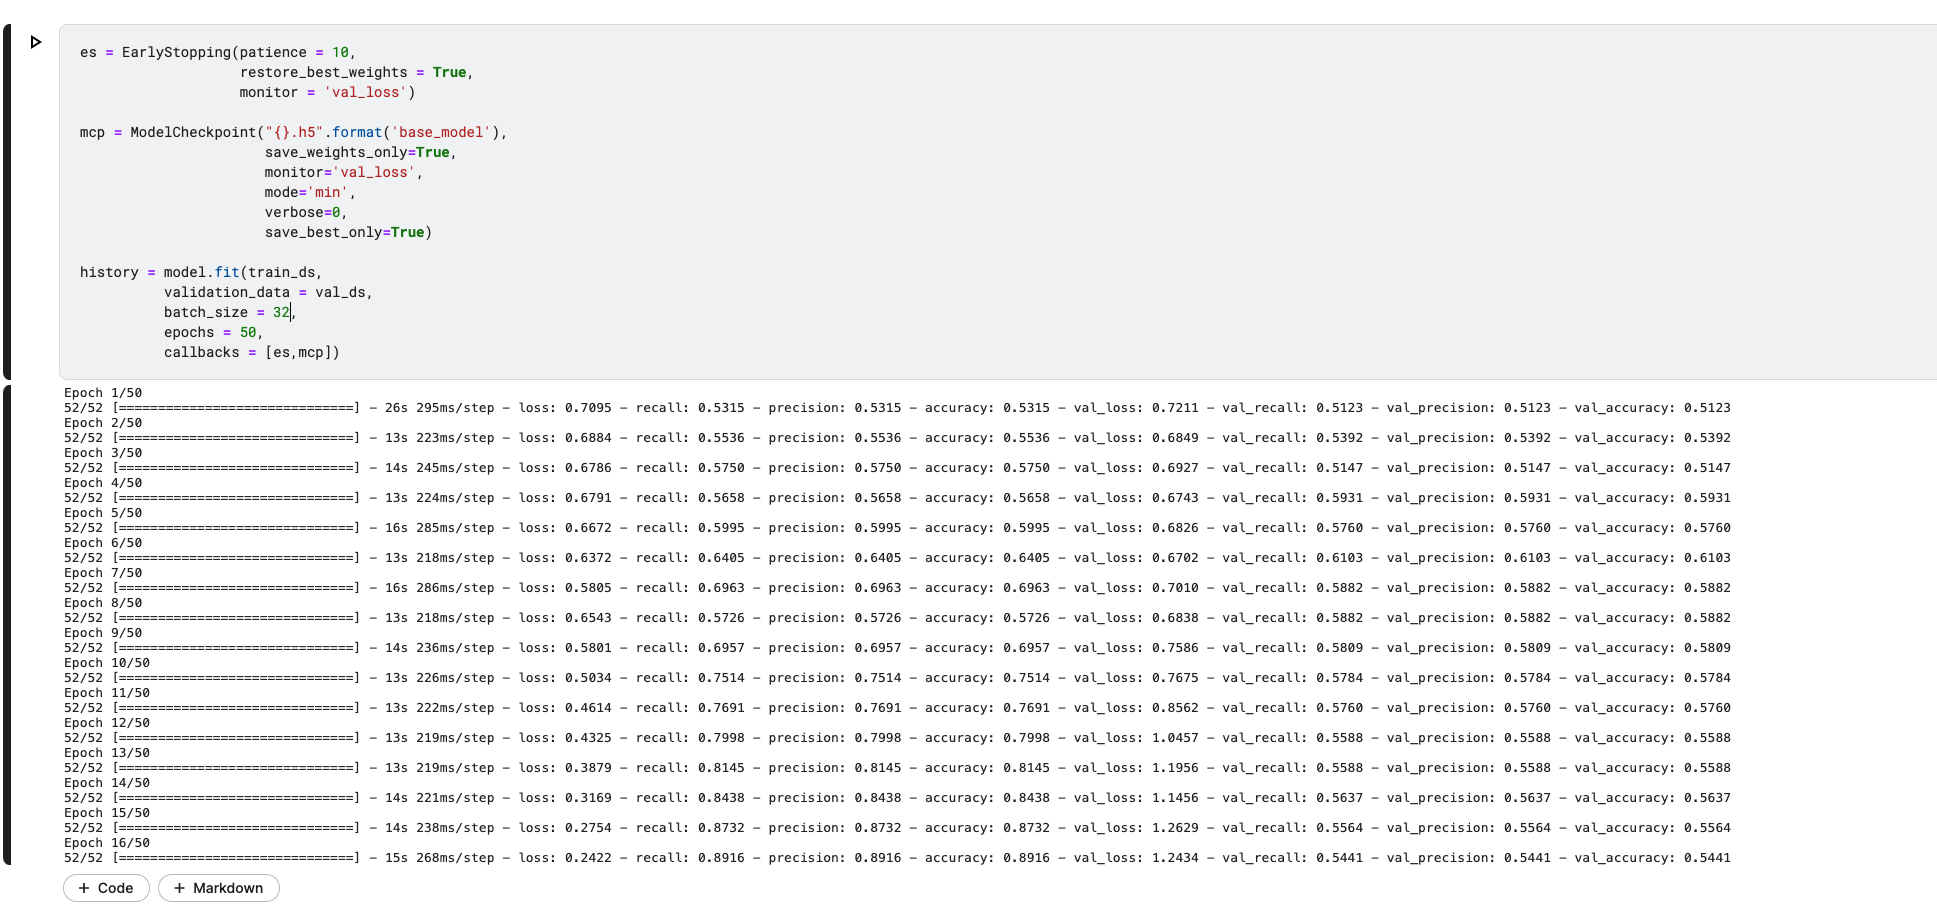

#### Initial baseline model with batch_size = 64 & epoch = 300: best val_accuracy = 0.6201
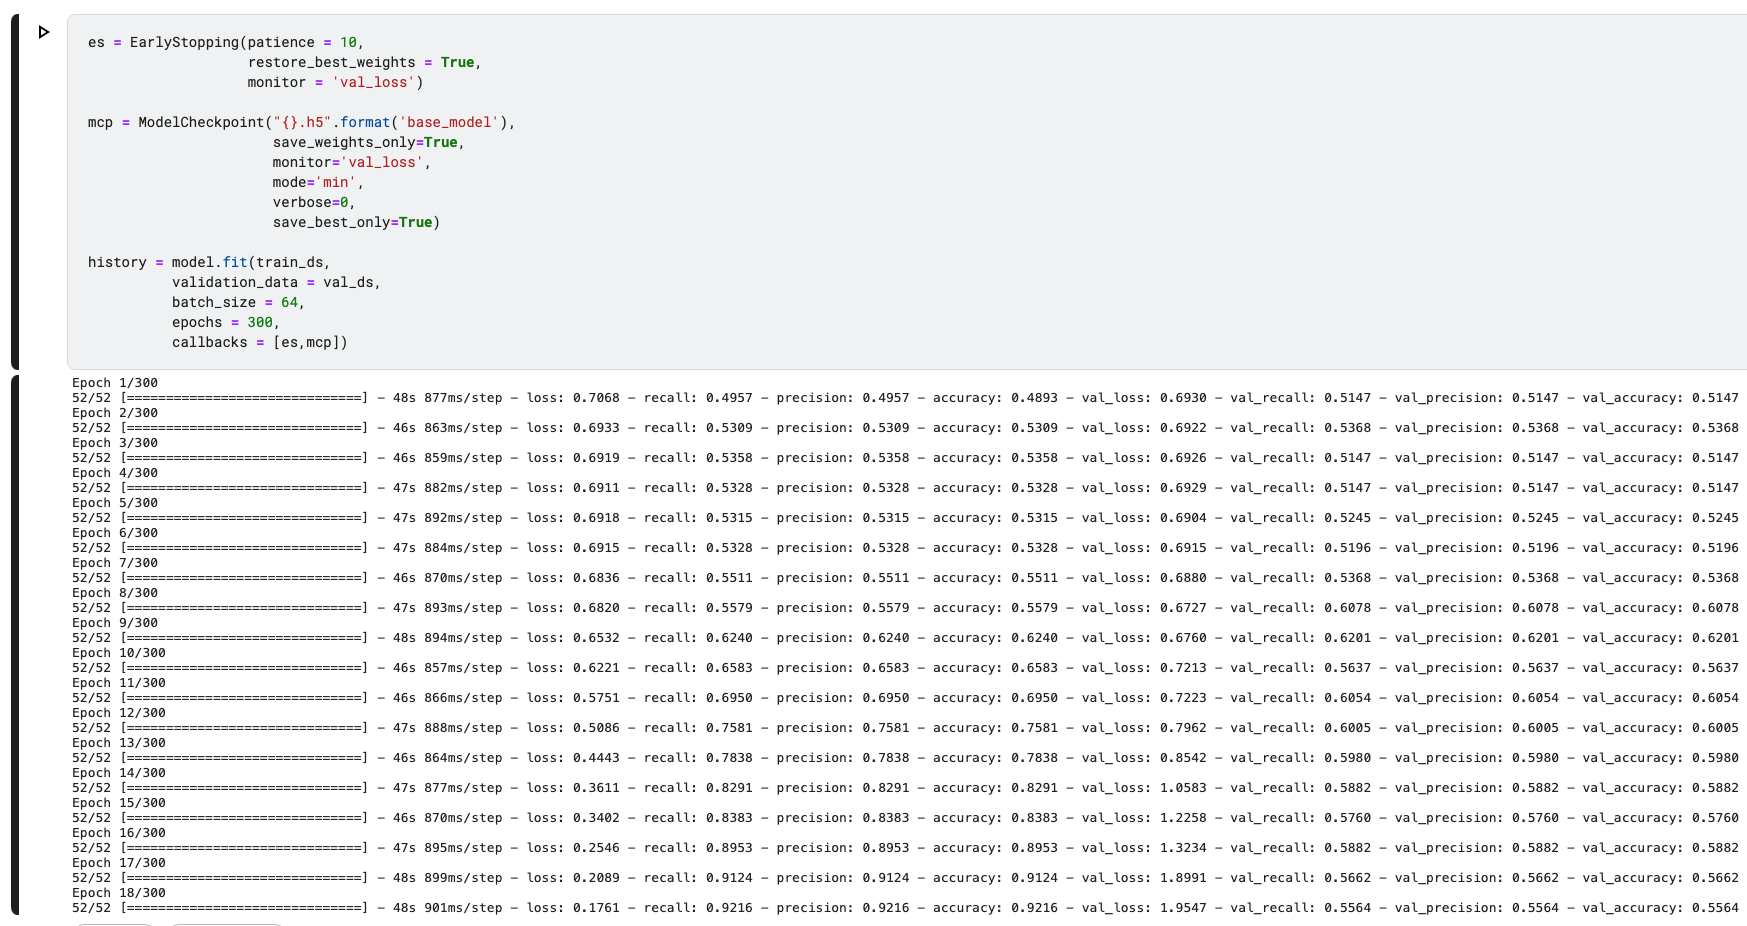

# Visualization of Learning Curves

In the process of training our deepfake detection model, it's essential to monitor the learning curves to gain insights into the model's performance and convergence. The `plot_loss_precision_recall_curve` function is designed for this purpose.

In [28]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

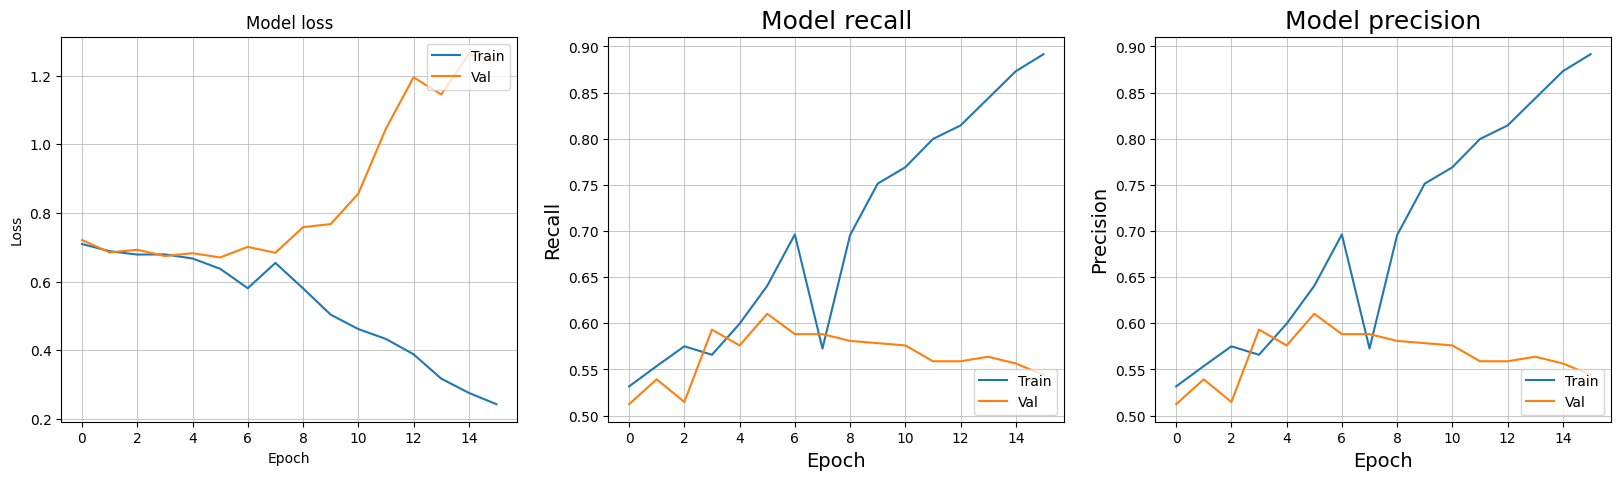

In [10]:
plot_loss_precision_recall_curve(history)

# Making Predictions

Now that we have built and trained our deepfake detection model, it's time to put it to use for making predictions on new data. Here's how the prediction phase works:

### Prediction with the test folder (3 subfolders that contain real and fake images: easy, medium, hard)

Main issue: labels the images from 1 to 3 (easy, medium and hard folder). Instead of fake / real in each folder.

To solve this, Malvina created a new local dataset: /kaggle/input/test-data-deepfake-images with the right folder structure.

In [42]:
test = image_dataset_from_directory(
    "/kaggle/input/deepfakedetection-lw/Project_Data/real_and_fake_face_test_data/",
    #color_mode = 'rgb',
    shuffle=True,
    batch_size = 32,
    image_size=image_size)

Found 150 files belonging to 3 classes.


1/1 [==============================] - 0s 248ms/step


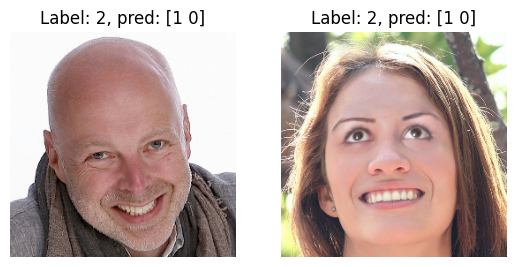

In [51]:
for images, labels in test:
    num_images_to_display = 2
    
    predictions = model.predict(images)
    predictions = where(predictions < 0.5,0, 1)
    
    for i in range(num_images_to_display):
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the tensor to a NumPy array
        plt.title(f"Label: {labels[i].numpy()}, pred: {predictions[i]}")
        plt.axis("off")
    
    plt.show()
    break
# label: [1. 0.] -> fake // label: [0. 1.] -> real
# Here label 0, 1 and 2 correspond to the folder name easy, medium, hard with real and fake picture inside

### Prediction with the new test folder (4 subfolders with  subfolders real/fake: easy, medium, hard, all)

In [54]:
test_easy = image_dataset_from_directory(
    "/kaggle/input/test-data-deepfake-images/real_and_fake_face_test_data/test_easy",
    color_mode = 'rgb',
    shuffle=True,
    batch_size = 32,
    label_mode = "categorical",
    image_size=image_size)

Found 50 files belonging to 2 classes.


1/1 [==============================] - 0s 239ms/step


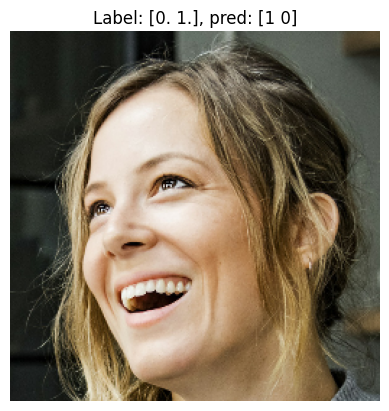

In [65]:
for images, labels in test_easy:
    num_images_to_display = 1
    
    predictions = model.predict(images)
    predictions = where(predictions < 0.5,0, 1)
    
    for i in range(num_images_to_display):
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the tensor to a NumPy array
        plt.title(f"Label: {labels[i].numpy()}, pred: {predictions[i]}")
        plt.axis("off")
    
    plt.show()
    break
# label: [1. 0.] -> fake // label: [0. 1.] -> real

### Prediction for the whole test dataset

In [ ]:
test_easy = image_dataset_from_directory(
    "/kaggle/input/test-data-deepfake-images/real_and_fake_face_test_data/test_easy",
    color_mode = 'rgb',
    shuffle=True,
    batch_size = 32,
    label_mode = "categorical",
    image_size=image_size)

In [62]:
predictions = model.predict(test_easy)
predictions = where(predictions < 0.5,0, 1)
predictions.numpy

2/2 [==============================] - 1s 108ms/step


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(50, 2), dtype=int32, numpy=
array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]], dtype=int32)>>

# Potential for Improvement

While this model architecture is promising, there are avenues for improvement:

- **Data Augmentation:** Augmenting the dataset with techniques like rotation, flipping, and zooming can enhance generalization.

- **Hyperparameter Tuning:** Experimenting with learning rates, batch sizes, and dropout rates can yield better results.

- **Model Evaluation:** Use appropriate metrics (e.g., accuracy, precision, recall, F1-score) and consider techniques like cross-validation for thorough evaluation.

- **More Complex Architectures:** Explore more complex CNN architectures or consider transfer learning from pre-trained models like VGG, ResNet, or Inception.

- **Handling Class Imbalance:** Address class imbalance with oversampling, undersampling, or class weights.

- **Regularization:** Adjust regularization strength to counter overfitting or underfitting.

- **Learning Rate Scheduling:** Implement learning rate scheduling techniques for fine-tuning model convergence.

The model's performance relies on your dataset's characteristics and specific deepfake detection needs. Experimentation and fine-tuning are key to achieving optimal results.


## Model simplification

We want to simplify our model so that it shows it's learning (instead of staying at val_accuracy = 0.5147). To do so, we will decrease the number of layers et avaluate the model again.
It doesn't work. We go back to the baseline model and increase number of epochs / batch_size / patience.

In [50]:
simplier_model = models.Sequential()

simplier_model.add(layers.Rescaling(1/255, input_shape=(image_size[0],image_size[1],3)))
simplier_model.add(layers.Conv2D(8, kernel_size = (4,4), activation='relu'))
simplier_model.add(layers.MaxPool2D(pool_size=(2,2)))
simplier_model.add(layers.Conv2D(8, kernel_size = (3,3), activation='relu'))
#simplier_model.add(layers.Dropout(rate=0.2))  

simplier_model.add(layers.Flatten())
simplier_model.add(layers.Dense(4, activation='relu'))
simplier_model.add(layers.Dense(2, activation='softmax'))

from keras.optimizers import Adam
opt = Adam(learning_rate=10)

simplier_model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [47]:
simplier_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 253, 253, 8)       392       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 126, 126, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 124, 124, 8)       584       
                                                                 
 flatten_12 (Flatten)        (None, 123008)            0         
                                                                 
 dense_25 (Dense)            (None, 4)                 492036    
                                                     

In [15]:
es = EarlyStopping(patience = 10)

history_simplier = simplier_model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size = 32,
        epochs = 20,
        callbacks = [es])

NameError: name 'simplier_model' is not defined

Check if our model has a better accuracy if we train / test on easy fake data

## ResNet50

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet50 = ResNet50(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
ResNet50.trainable = False
ResNet50 = Sequential([
    ResNet50,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])
from tensorflow.keras.applications.resnet50 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

In [14]:
mcp = ModelCheckpoint("{}.h5".format('ResNet50_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

from tensorflow.keras.optimizers import Adam
ResNet50.compile(optimizer=Adam(learning_rate=0.1), 
              loss='binary_crossentropy', 
              metrics=metrics)

hist_ResNet50 = ResNet50.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 64,
          epochs = 1000,
          callbacks = [es,mcp])

NameError: name 'es' is not defined